# resnet18

## 数据

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import matplotlib.pyplot as plt
import sys

# 训练集数据变换 数据增强
transform_train = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 测试集数据变换 不进行数据增强
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 数据集
train_dataset = datasets.Flowers102(root=r"D:\code\data\Flowers102", split='test', download=True,
                                    transform=transform_train)
test_dataset = datasets.Flowers102(root=r"D:\code\data\Flowers102", split='train', download=True,
                                   transform=transform_test)
# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

## 模型

In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)
# 冻结模型参数
for parameter in model.parameters():
    parameter.requires_grad = False
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# 改变模型的输出层
model.fc = nn.Linear(in_features=512, out_features=102, bias=True)
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

## 模型训练

Epoch: 0  Loss: 2.593224643462595  Acc: 1.9627450980392156
Epoch: 10  Loss: 2.052673872980288  Acc: 4.8313725490196076
Epoch: 20  Loss: 1.8905602267836579  Acc: 5.1911764705882355
100%|██████████| 30/30 [14:01<00:00, 28.06s/it]


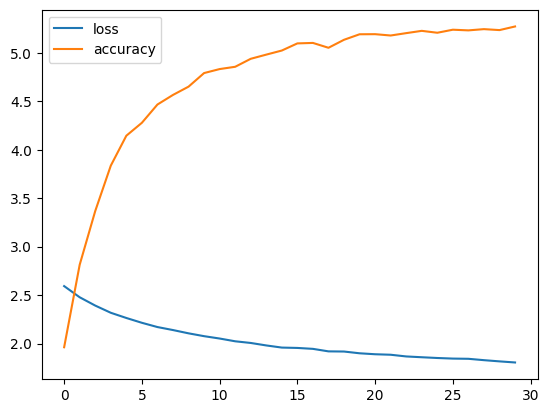

Accuracy:  5.270588235294118


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# 定义模型 优化器 损失函数
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# epoch 训练
num_epochs = 30
loss_history = []
acc_history = []

for epoch in tqdm(range(num_epochs), file=sys.stdout):
    total_loss = 0
    total_correct = 0

    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 数据移动到指定设备
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 预测 损失函数 反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 记录训练集loss
        total_loss += loss.item()

    # 模型测试 不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # 数据移动到指定设备
            inputs = inputs.to(device)
            labels = labels.to(device)
            # 预测
            outputs = model(inputs)
            # 记录测试集correct
            total_correct += (outputs.argmax(1) == labels).sum().item()

    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))
    acc_history.append(total_correct / len(test_dataset))

    # 打印中间值
    if epoch % 10 == 0:
        tqdm.write('Epoch: {0}  Loss: {1}  Acc: {2}'.format(epoch, loss_history[-1], acc_history[-1]))

# 绘制曲线
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()
# 输出准确率
print('Accuracy: ', acc_history[-1])

# VIT

## 数据

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import matplotlib.pyplot as plt
import sys

# 训练集数据变换 数据增强
transform_train = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 测试集数据变换 不进行数据增强
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 数据集
train_dataset = datasets.Flowers102(root=r"D:\code\data\Flowers102", split='test', download=True,
                                    transform=transform_train)
test_dataset = datasets.Flowers102(root=r"D:\code\data\Flowers102", split='train', download=True,
                                   transform=transform_test)
# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

## 模型

In [17]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
# 冻结参数
for parameter in model.parameters():
    parameter.requires_grad = False
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
# 修改模型的输出层
model.heads = nn.Linear(in_features=768, out_features=102, bias=True)
for name, param in model.named_parameters():
    print(name, param.requires_grad)

class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

## 模型训练

Epoch: 0  Loss: 2.5854631548488696  Acc: 2.014705882352941
Epoch: 10  Loss: 2.009010609662016  Acc: 5.026470588235294
Epoch: 20  Loss: 1.8183335730519419  Acc: 5.402941176470589
100%|██████████| 30/30 [19:47<00:00, 39.57s/it]


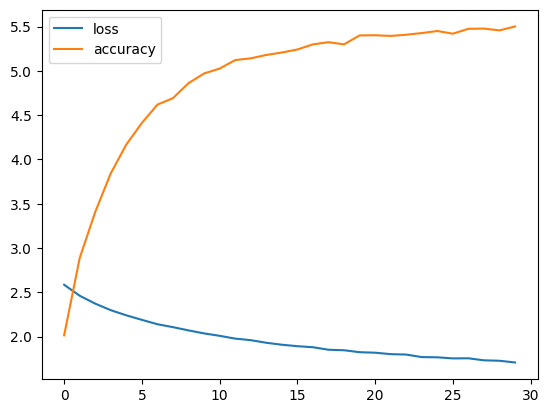

Accuracy:  5.5019607843137255


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# 定义模型 优化器 损失函数
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# epoch 训练
num_epochs = 30
loss_history = []
acc_history = []

for epoch in tqdm(range(num_epochs), file=sys.stdout):
    total_loss = 0
    total_correct = 0

    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 数据移动到指定设备
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 预测 损失函数 反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 记录训练集loss
        total_loss += loss.item()

    # 模型测试 不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # 数据移动到指定设备
            inputs = inputs.to(device)
            labels = labels.to(device)
            # 预测
            outputs = model(inputs)
            # 记录测试集correct
            total_correct += (outputs.argmax(1) == labels).sum().item()

    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))
    acc_history.append(total_correct / len(test_dataset))

    # 打印中间值
    if epoch % 10 == 0:
        tqdm.write('Epoch: {0}  Loss: {1}  Acc: {2}'.format(epoch, loss_history[-1], acc_history[-1]))

# 绘制曲线
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()
# 输出准确率
print('Accuracy: ', acc_history[-1])